In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Transforming data to DateTime

In [2]:
fuelPrice = pd.read_csv('C:/ICUP/InformatiCup2018-master/Eingabedaten/Benzinpreise/1.csv', header = None, delimiter = ';', names = ('Time', 'Price'))
index = pd.DatetimeIndex(fuelPrice.Time)
fuelPrice.drop('Time', axis = 1, inplace = True)
fuelPrice.set_index(index, inplace = True)
fuelPrice = fuelPrice['2016':'2017']

# Resample by hour


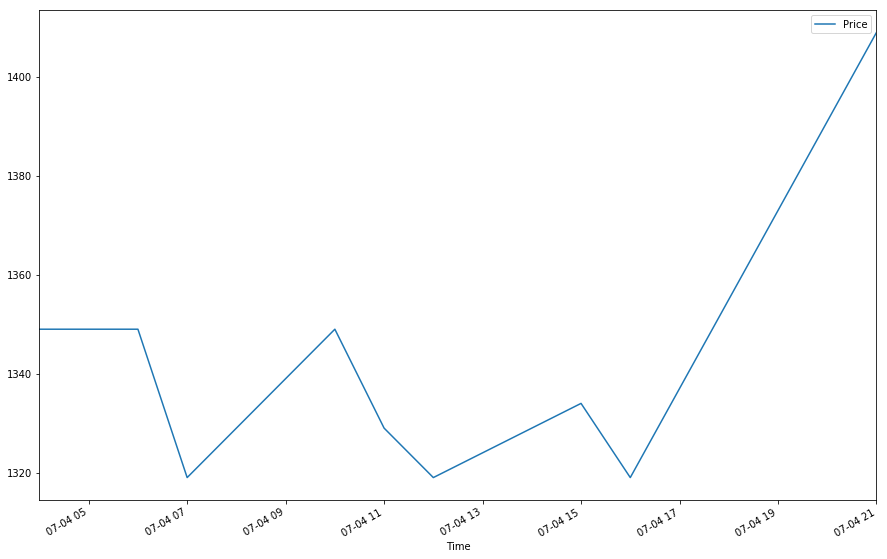

In [4]:
hour_bday_fuelPrice = fuelPrice[fuelPrice.index.dayofweek < 5]
hour_bday_fuelPrice = hour_bday_fuelPrice.resample('H').mean()
hour_bday_fuelPrice.dropna(inplace = True)
hour_bday_fuelPrice['2017-07-04'].plot(figsize=(15, 10))
plt.show()

# Check stationarity using augmented Dickey-Fuller test


In [5]:
def adftest(X):
    test = adfuller(X.iloc[:,0].values)

    print('Test Statistic: ',test[0])
    print('p-value: ',test[1])
    print('Lags: ',test[2])
    print('Observation number: ',test[3])
    print('Critical value 1%: ',test[4]['1%'])
    print('Critical value 5%: ',test[4]['5%'])
    print('Critical value 10%: ',test[4]['10%'])
    #print('Test Statistic: {};{}p-value: {};{}Lags: {};{}Observation number: {};'.format(test[0], '\n', test[1], '\n', test[2], '\n', test[3]))
    #print('Critical value 1%: {};{} Critical value 5%: {};{} Critical value 10% : {}'.format(test[4]['1%'], '\n', test[4]['5%'], '\n', test[4]['10%']))
    if (test[0]>test[4]['1%']) & (test[1]>0.05):
        print ('Time series is not stationary.')
    else:
        print('According to ADF time series is stationary.')
    return

In [7]:
adftest(hour_bday_fuelPrice)

Test Statistic:  -2.29244216145
p-value:  0.174417112454
Lags:  17
Observation number:  3105
Critical value 1%:  -3.43245779851
Critical value 5%:  -2.86247129396
Critical value 10%:  -2.5672657503
Time series is not stationary.


# Decompose time series


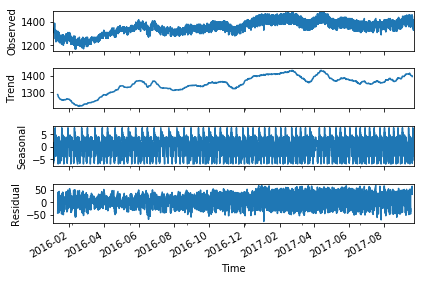

In [8]:
dec = sm.tsa.seasonal_decompose(hour_bday_fuelPrice.interpolate(), freq = 50, model = 'additive')
dec.plot()
plt.show()

# Non-linear log transformation

In [9]:
hour_bday_fuelPrice_log = np.log(hour_bday_fuelPrice)
adftest(hour_bday_fuelPrice_log)

Test Statistic:  -2.2592570581
p-value:  0.185445129152
Lags:  17
Observation number:  3105
Critical value 1%:  -3.43245779851
Critical value 5%:  -2.86247129396
Critical value 10%:  -2.5672657503
Time series is not stationary.


# Differencing

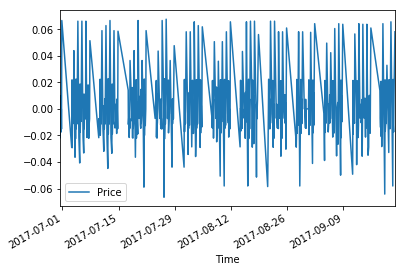

In [10]:
diff = hour_bday_fuelPrice_log - hour_bday_fuelPrice_log.shift()
diff.tail(500).plot()
plt.show()

In [11]:
diff.dropna(inplace = True)
adftest(diff)

Test Statistic:  -21.344000157
p-value:  0.0
Lags:  16
Observation number:  3105
Critical value 1%:  -3.43245779851
Critical value 5%:  -2.86247129396
Critical value 10%:  -2.5672657503
According to ADF time series is stationary.


# Model

In [17]:
mod = sm.tsa.statespace.SARIMAX(hour_bday_fuelPrice_log, order = (4,1,0), seasonal_order=(4,1,0,12))
modf = mod.fit(disp = 0)
modf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Price   No. Observations:                 3123
Model:             SARIMAX(4, 1, 0)x(4, 1, 0, 12)   Log Likelihood                7183.146
Date:                            Wed, 06 Dec 2017   AIC                         -14348.292
Time:                                    11:27:26   BIC                         -14293.873
Sample:                                01-04-2016   HQIC                        -14328.758
                                     - 09-21-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4657      0.020    -23.590      0.000      -0.504      -0.427
ar.L2         -0.3778      0.019    -19.519      0.000      -0.416      -0.340
ar.L3         -0.3210      0.020    -15.778      0.000      -0.361      -0.281
ar.L4         -0.2809      0.018    -15.371      0.000      -0.317      -0.245
ar.S.L12      -0.8996      0.018    -49.914      0.000      -0.935      -0.864
ar.S.L24      -0.6850      0.023    -29.625      0.000      -0.730      -0.640
ar.S.L36      -0.4401      0.023    -19.124      0.000      -0.485      -0.395
ar.S.L48      -0.2112      0.017    -12.257      0.000      -0.245      -0.177
sigma2         0.0006   1.49e-05     38.669      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                      431.55   Jarque-Bera (JB):               166.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

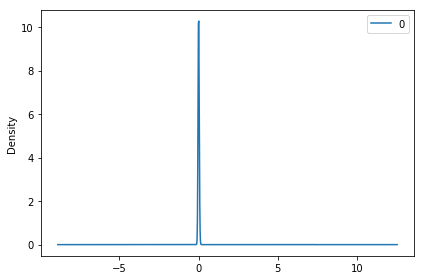

In [20]:
residuals = pd.DataFrame(modf.resid)
residuals.plot(kind='kde')
plt.tight_layout()
plt.show()

In [21]:
residuals.describe()

,0
count,3123.000000
mean,0.001166
std,0.145209
min,-3.537974
25%,-0.016963
50%,-0.002581
75%,0.013912
max,7.177019


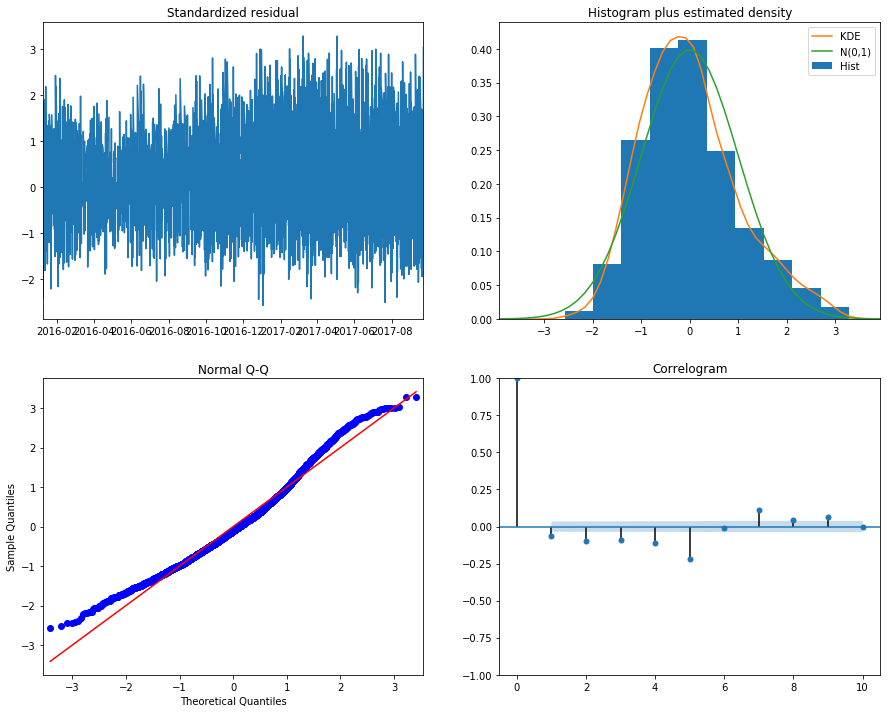

In [22]:
modf.plot_diagnostics(figsize=(15, 12))

# In-sample prediction

In [23]:
t = hour_bday_fuelPrice_log.as_matrix()
size = int(len(t) - 15)
train,  test = t[0:size], t[size:len(t)]
log = [x for x in train]
predictions = list()
print('Predicted vs Expected:')
for t in range(len(test)):
    mod = sm.tsa.statespace.SARIMAX(log, order = (4,1,0), seasonal_order=(4,1,0,12)).fit(disp = 0)
    res = mod.forecast()
    yhat = res[0]
    predictions.append(float(yhat))
    obs = test[t]
    log.append(obs)
    print('predicted=%.2f, expected=%.2f' % (np.exp(yhat), np.exp(obs)))


Predicted vs Expected:
predicted=1368.40, expected=1349.00
predicted=1382.60, expected=1394.00
predicted=1359.14, expected=1349.00
predicted=1352.24, expected=1379.00
predicted=1368.51, expected=1364.00
predicted=1373.96, expected=1349.00
predicted=1357.03, expected=1349.00
predicted=1353.17, expected=1329.00
predicted=1371.31, expected=1419.00
predicted=1393.16, expected=1339.00
predicted=1331.03, expected=1369.00
predicted=1350.31, expected=1352.33
predicted=1359.46, expected=1329.00
predicted=1361.85, expected=1339.00
predicted=1319.26, expected=1419.00


In [24]:
mean_squared_error(test, predictions)

0.00073761143162093615

In [36]:
H = 20
mod = sm.tsa.statespace.SARIMAX(hour_fuelPrice, order = (4,1,0), seasonal_order=(4,1,0,8)).fit(disp = 0)
forecasty = mod.forecast(steps = H)
index = pd.date_range(hour_fuelPrice.index[-1], periods = H, freq = 'H')
forecasted_price = pd.DataFrame(forecasty[0], index = index)
hour_fuelPrice = hour_fuelPrice.append(forecasted_price)

In [37]:
print(hour_fuelPrice.tail(H+30))

                           Price            0
2017-09-18 05:00:00  1449.000000          NaN
2017-09-18 07:00:00  1429.000000          NaN
2017-09-18 10:00:00  1459.000000          NaN
2017-09-18 11:00:00  1429.000000          NaN
2017-09-18 13:00:00  1429.000000          NaN
2017-09-18 14:00:00  1389.000000          NaN
2017-09-18 15:00:00  1404.000000          NaN
2017-09-18 16:00:00  1389.000000          NaN
2017-09-18 17:00:00  1359.000000          NaN
2017-09-18 21:00:00  1449.000000          NaN
2017-09-19 08:00:00  1359.000000          NaN
2017-09-19 10:00:00  1389.000000          NaN
2017-09-19 11:00:00  1365.666667          NaN
2017-09-19 13:00:00  1349.000000          NaN
2017-09-19 15:00:00  1364.000000          NaN
2017-09-19 16:00:00  1349.000000          NaN
2017-09-19 21:00:00  1394.000000          NaN
2017-09-20 08:00:00  1349.000000          NaN
2017-09-20 10:00:00  1379.000000          NaN
2017-09-20 11:00:00  1364.000000          NaN
2017-09-20 14:00:00  1349.000000  

In [ ]:
hour_fuelPrice.tail(H+30).plot()
plt.show()